In [1]:
# LSTM Model configuration
# Packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.metrics import mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, BatchNormalization, GaussianNoise
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
import random

# ---- Replicability ----
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)
random.seed(SEED)

# ---------- HYPERPARAMETRES ----------
FILEPATH = '/content/datas.xls'
LOOK_BACK = 5
LSTM_UNITS = 64
BATCH_SIZE = 30
EPOCHS = 500
TEST_LAST_YEARS = 4
SCALE_METHOD = 'minmax'
# ---------------------------------

# 1) Loading data
df = pd.read_excel(FILEPATH)

# checking the columns
assert {'Province','Annee','Taux'}.issubset(df.columns), "Colonnes attendues : Province, Annee, Taux"

# Data sorting
df = df.sort_values(['Province','Annee']).reset_index(drop=True)

# Province List
provinces = df['Province'].unique()
n_provinces = len(provinces)

# Reorganizing the series by province
series_dict = {}
scalers_dict = {}

for prov in provinces:
    s = df[df['Province']==prov]['Taux'].values.astype(float)

    scaler = MinMaxScaler() if SCALE_METHOD=='minmax' else StandardScaler()
    s_scaled = scaler.fit_transform(s.reshape(-1,1)).flatten()

    series_dict[prov] = s_scaled
    scalers_dict[prov] = scaler

n_years = len(df[df['Province']==provinces[0]])

# 2) Creating multi-series sliding windows
X_list = []
y_list = []
info_list = []

for prov in provinces:
    s = series_dict[prov]
    for t in range(LOOK_BACK, len(s)):
        X_list.append(s[t-LOOK_BACK:t])
        y_list.append(s[t])
        info_list.append((prov, t))

X = np.array(X_list).reshape(-1, LOOK_BACK, 1)
y = np.array(y_list).reshape(-1, 1)

# Temporal split
years_idx = np.array([t for _,t in info_list])
test_threshold = n_years - TEST_LAST_YEARS

train_mask = years_idx < test_threshold
test_mask = years_idx >= test_threshold

X_train, X_test = X[train_mask], X[test_mask]
y_train, y_test = y[train_mask], y[test_mask]
info_test  = np.array(info_list)[test_mask]

# Shuffling trainset
perm = np.random.permutation(X_train.shape[0])
X_train, y_train = X_train[perm], y_train[perm]

# 3) LSTM model architecture
def build_model(units=LSTM_UNITS):
    model = Sequential([
        Input(shape=(LOOK_BACK,1)),
        GaussianNoise(0.01),
        LSTM(units, return_sequences=True),
        Dropout(0.25),
        LSTM(units//2),
        BatchNormalization(),
        Dense(units//2, activation="relu"),
        Dropout(0.15),
        Dense(1)
    ])
    model.compile(optimizer=Adam(1e-3), loss="mse")
    return model

# callbacks
es = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
rlr = ReduceLROnPlateau(monitor='val_loss', patience=8, factor=0.5)

model = build_model()
model.fit(
    X_train, y_train,
    validation_split=0.15,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[es, rlr],
    verbose=2
)

# -------- EVALUATION PART --------
y_pred_scaled = model.predict(X_test)

y_test_orig = []
y_pred_orig = []

for k, (prov, t) in enumerate(info_test):
    scaler = scalers_dict[prov]

    y_test_orig.append(scaler.inverse_transform([[y_test[k,0]]])[0,0])
    y_pred_orig.append(scaler.inverse_transform([[y_pred_scaled[k,0]]])[0,0])

y_test_orig = np.array(y_test_orig)
y_pred_orig = np.array(y_pred_orig)
rmse = np.sqrt(mean_squared_error(y_test_orig, y_pred_orig))
mae = mean_absolute_error(y_test_orig, y_pred_orig)

print()
print("=== Performance Evaluation  ===")
print("R² :", r2_score(y_test_orig, y_pred_orig))
print("MSE :", mean_squared_error(y_test_orig, y_pred_orig))
print("RMSE :", rmse)
print("MAE  :", mae)

# --------- PREVISION for 2021 + IC ----------
def mc_dropout_predict(model, x_scaled, scaler, n_iter=200):
    preds = []
    for _ in range(n_iter):
        out = model(x_scaled, training=True).numpy()[0,0]
        preds.append(out)
    preds = np.array(preds).reshape(-1,1)
    preds_orig = scaler.inverse_transform(preds).flatten()
    return preds_orig.mean(), preds_orig.std()

pred2021 = []
ic_inf = []
ic_sup = []

for prov in provinces:
    seq = series_dict[prov][-LOOK_BACK:].reshape(1,LOOK_BACK,1)
    scaler = scalers_dict[prov]

    mu, sigma = mc_dropout_predict(model, seq, scaler)

    pred2021.append(mu)
    ic_inf.append(mu - 1.96*sigma)
    ic_sup.append(mu + 1.96*sigma)

# Adding the predictions to DF
df_res = pd.DataFrame({
    'Province': provinces,
    'Pred_2021': pred2021,
    'IC95_inf': ic_inf,
    'IC95_sup': ic_sup
})

print(df_res)


Epoch 1/500
3/3 - 5s - 2s/step - loss: 0.2036 - val_loss: 0.1181 - learning_rate: 1.0000e-03
Epoch 2/500
3/3 - 0s - 59ms/step - loss: 0.1433 - val_loss: 0.1086 - learning_rate: 1.0000e-03
Epoch 3/500
3/3 - 0s - 81ms/step - loss: 0.1264 - val_loss: 0.1018 - learning_rate: 1.0000e-03
Epoch 4/500
3/3 - 0s - 33ms/step - loss: 0.1052 - val_loss: 0.0975 - learning_rate: 1.0000e-03
Epoch 5/500
3/3 - 0s - 33ms/step - loss: 0.1204 - val_loss: 0.0956 - learning_rate: 1.0000e-03
Epoch 6/500
3/3 - 0s - 34ms/step - loss: 0.1102 - val_loss: 0.0945 - learning_rate: 1.0000e-03
Epoch 7/500
3/3 - 0s - 34ms/step - loss: 0.1073 - val_loss: 0.0938 - learning_rate: 1.0000e-03
Epoch 8/500
3/3 - 0s - 34ms/step - loss: 0.0842 - val_loss: 0.0931 - learning_rate: 1.0000e-03
Epoch 9/500
3/3 - 0s - 35ms/step - loss: 0.0973 - val_loss: 0.0924 - learning_rate: 1.0000e-03
Epoch 10/500
3/3 - 0s - 36ms/step - loss: 0.1090 - val_loss: 0.0918 - learning_rate: 1.0000e-03
Epoch 11/500
3/3 - 0s - 35ms/step - loss: 0.0806 - 

In [2]:
# -----------------------------
# 1) Preparing data for graphs
# -----------------------------
df['Annee'] = df['Annee'].astype(int)

# Actual and predicted rates for 2018-2020
df_pred_1820 = pd.DataFrame({
    'Province': [p for p,_ in info_test],
    't_index':  [t for _,t in info_test],
    'y_test':   y_test_orig,
    'y_pred':   y_pred_orig
})
year0 = int(df['Annee'].min())
df_pred_1820['Annee'] = df_pred_1820['t_index'].astype(int) + year0
df_pred_1820 = df_pred_1820[df_pred_1820['Annee'].isin([2018, 2019, 2020])]

df_real_1820 = df[df['Annee'].isin([2018, 2019, 2020])][['Province','Annee','Taux']]
df_1820 = pd.merge(df_real_1820,
                   df_pred_1820[['Province','Annee','y_pred']],
                   on=['Province','Annee'], how='left')
df_1820 = df_1820.rename(columns={'Taux':'Taux_reel','y_pred':'Taux_predit'})
df_1820['Pred_2021'] = pd.NA
df_1820['IC95_inf'] = pd.NA
df_1820['IC95_sup'] = pd.NA

# 2021 Forecasts
df_prev_2021 = df_res.copy()
df_prev_2021['Annee'] = 2021
df_prev_2021 = df_prev_2021.rename(columns={'Pred_2021':'Pred_2021'})
df_prev_2021['Taux_reel'] = pd.NA
df_prev_2021['Taux_predit'] = pd.NA
df_prev_2021 = df_prev_2021[['Province','Annee','Taux_reel','Taux_predit','Pred_2021','IC95_inf','IC95_sup']]

# Concatenating all years
df_final = pd.concat([df_1820, df_prev_2021], axis=0)
df_final = df_final.sort_values(['Annee','Province']).reset_index(drop=True)

# -----------------------------
# 2) Exporting the selected dataframe for saving
# -----------------------------
output_path = "LSTM_Forecasts_WIth_CI.xlsx"
df_final.to_excel(output_path, index=False)

print("File exported successfully :", output_path)


/tmp/ipython-input-2101831201.py:35: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_final = pd.concat([df_1820, df_prev_2021], axis=0)


File exported successfully : LSTM_Forecasts_WIth_CI.xlsx


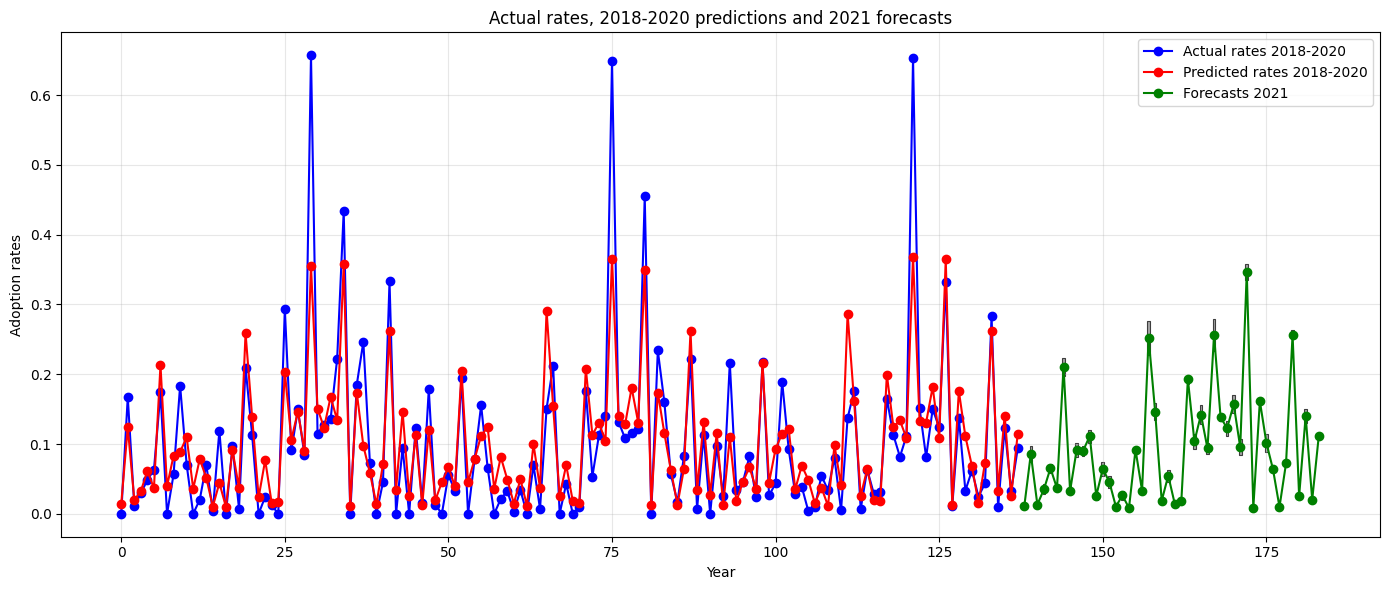

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Loading the “LSTM_forecast_results” file for the graphs
file_path = "LSTM_Forecasts_WIth_CI.xlsx"
df = pd.read_excel(file_path)

# Sorting by year then province
df = df.sort_values(['Annee','Province']).reset_index(drop=True)

# ----- Selecting not NA values from the series -----
# 2018-2020 : real rates
reels = df.loc[df['Taux_reel'].notna(), 'Taux_reel'].values

# 2018-2020 : predicted rates
predits = df.loc[df['Taux_predit'].notna(), 'Taux_predit'].values

# 2021 : Forecasts + IC95%
df_2021 = df[df['Annee']==2021].reset_index(drop=True)
pred_2021 = df_2021['Pred_2021'].values
ic_inf = df_2021['IC95_inf'].values
ic_sup = df_2021['IC95_sup'].values

# Concatenating 2018-2020 predictions and 2021 forecasts
x_reels = np.arange(len(reels))
x_predits = np.arange(len(predits))
x_2021 = np.arange(len(predits), len(predits) + len(pred_2021))


plt.figure(figsize=(14,6))

# Actual rates 2018-2020
plt.plot(np.arange(len(reels)), reels, color='blue', marker='o', linestyle='-', label='Actual rates 2018-2020')

# Predicted rate 2018-2020
plt.plot(np.arange(len(predits)), predits, color='red', marker='o', linestyle='-', label='Predicted rates 2018-2020')

# Forecasts 2021
plt.plot(x_2021, pred_2021, color='green', marker='o', linestyle='-', label='Forecasts 2021')

# IC 2021
for i, (x, mu, low, high) in enumerate(zip(x_2021, pred_2021, ic_inf, ic_sup)):
    plt.fill_between([x-0.2, x+0.2], [low, low], [high, high], color='gray', alpha=0.7, edgecolor='black', linewidth=0.8)

plt.xlabel('Year')
plt.ylabel('Adoption rates')
plt.title('Actual rates, 2018-2020 predictions and 2021 forecasts')
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


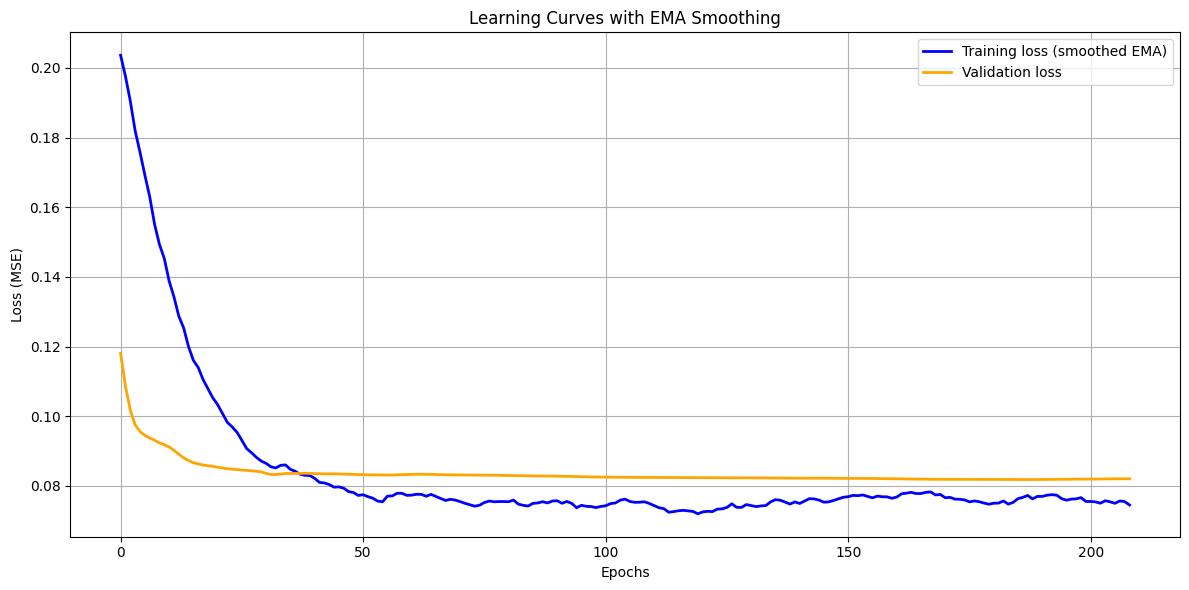

In [ ]:
# =======================================
#   LEARNING CURVES + SMOOTHING (EMA)
# =======================================

# Fonction de smoothing (EMA) — scientifiquement standard
def smooth_curve(points, alpha=0.1):
    """
    Exponential Moving Average (EMA)
    alpha = 0.1 recommandé pour deep learning
    """
    smoothed = []
    for p in points:
        if smoothed:
            smoothed.append(alpha * p + (1 - alpha) * smoothed[-1])
        else:
            smoothed.append(p)
    return smoothed

history_dict = model.history.history
train_loss_raw = history_dict['loss']
val_loss_raw = history_dict['val_loss']

# Lissage de la training loss
train_loss_smooth = smooth_curve(train_loss_raw, alpha=0.1)

# --- Plot ---
plt.figure(figsize=(12,6))

#plt.plot(train_loss_raw, color="blue", alpha=0.3, label="Training loss (raw)")
plt.plot(train_loss_smooth, color="blue", linewidth=2, label="Training loss ")
plt.plot(val_loss_raw, color="orange", linewidth=2, label="Validation loss")

plt.title("Learning Curves")
plt.xlabel("Epochs")
plt.ylabel("Loss (MSE)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
